# Room Classifier by Daniel Collado

## Import Data and libraries

Import all librarys we need during the notebook

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
import scipy
from keras.applications import MobileNetV2, VGG16, InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.utils import load_img, img_to_array
from keras.models import load_model
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import os
import seaborn as sns

Check if tensorflow is using the GPU

In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("You are using the GPU for the processing")


You are using the GPU for the processing


#### Load the data of the directory

In [4]:
#In case you charge this notebook using Google colab uncomment the next code to load your data uploaded in your Drive.
# from google.colab import drive
# drive.mount('/content/drive/')
# data_dir = "/content/drive/MyDrive/data/Train"
# test_dir = "/content/drive/MyDrive/data/Test"

data_dir = "./data/Train/"
test_dir = "./data/Test"

Split the data in 2 dataset: 1 for train and another for validation. The validation will use the 20% of the data. We are going to use a batch size of 32 because it is the maximum that my computer can execute.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 3256 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 4070 files belonging to 5 classes.
Using 814 files for validation.


Create these variables that we are going to use during the notebook to refer each class.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f'This is the list of the names of all classes {class_names}')

This is the list of the names of all classes ['Bathroom', 'Bedroom', 'House Map', 'Kitchen', 'Living Room']


#### Dataset exploration

Show a sample of the 9 first images with their own labels

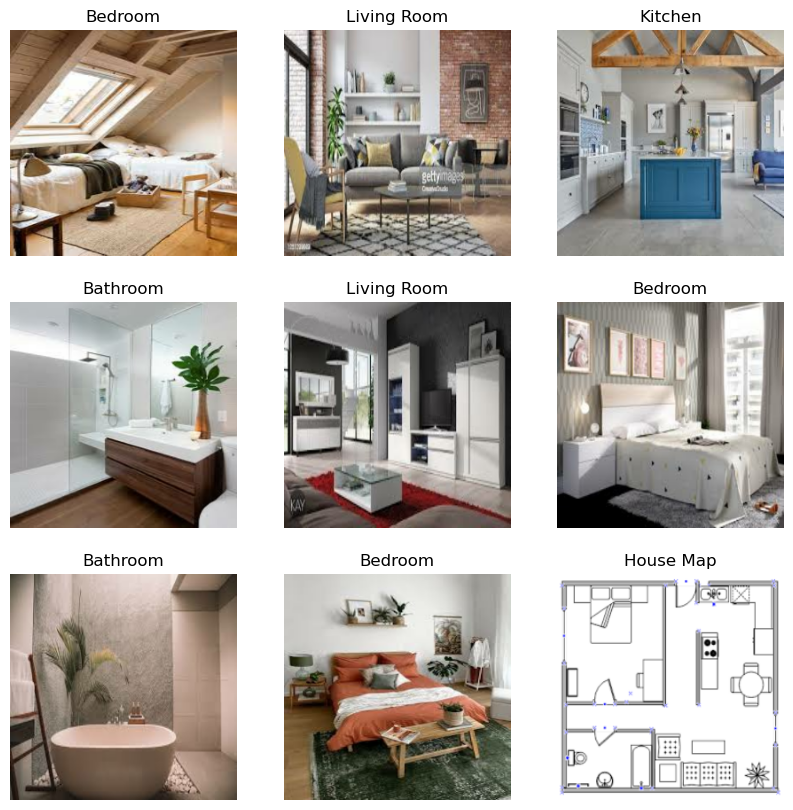

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We see that the each batch have 32 images and each image have the dimensions of (256,256,3) where 3 mean the RGB of each pixel

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Lets show how much images we have in the training for class. We can see that we have less images of the House Map class because is not a difficult class to be reconigzed by the model and we need more images of the other classes which are more difficult to difference between them.

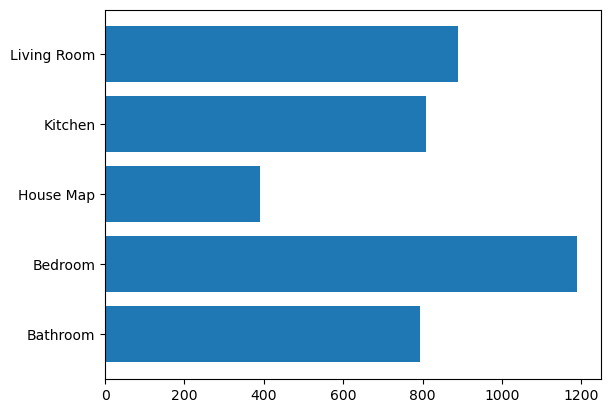

In [9]:
# Obtain a list of each folder of the directory
folders = os.listdir(data_dir)

# Arrays to store the folder names and number of files in each
folder_names = []
num_files = []

# Loop through the list and count the number of files in each folder
for item in folders:
    if os.path.isdir(os.path.join(data_dir, item)):
        # Get a list of all files in the folder
        files_in_folder = os.listdir(os.path.join(data_dir, item))
        # Count the number of files in the folder
        count = len([f for f in files_in_folder if os.path.isfile(os.path.join(data_dir, item, f))])
        # Add the folder name and number of files to the arrays
        folder_names.append(item)
        num_files.append(count)

# Create the horizontal bar chart
plt.barh(folder_names, num_files)

# Show the chart
plt.show()

## Preprocess data

Scale the image dividing it by 255, normalizing all the data.

In [10]:
normalization_layer = Rescaling(1./255)

In [11]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_valid_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
#Print the min and max to check if is right normalized [0,1] 
print(np.min(first_image),np.max(first_image))

0.011127547 1.0


## Train the models

### Model trained using convultional neural network

The code above is defining a convolutional neural network (conv_model) for a room image classifier using the Sequential model from the Keras library.

The `input_shape` parameter is passed as an argument to the function and is used to define the shape of the input images. The model is defined with a sequential structure and starts with a `Conv2D` layer with 32 filters, a kernel size of 3x3 and the input shape passed as an argument. The `Conv2D` layer is responsible for applying convolutional filters to the input image to extract features.

The next layer is an `Activation` layer with the "relu" function, which is used to introduce non-linearity to the model. This layer applies the rectified linear unit (ReLU) function to the output of the previous layer.

After that, a `MaxPooling2D` layer is added to the model, which is used to reduce the spatial dimensions of the output of the previous layer. It is used to reduce the number of parameters and computation in the network, and also to control overfitting by reducing the number of parameters.

The same structure is repeated three times, each time with 32 filters, a kernel size of 3x3 and a `Activation` layer with "relu" function followed by a `MaxPooling2D` layer.

The next step is to flatten the output of the last convolutional layer, this is done by adding a `Flatten` layer to the model. Then, the model has a fully connected layer (Dense) with 1024 neurons and an `Activation` layer with "relu" function, this layer is used to learn the higher-level features from the previous convolutional layers.

The model also contains a `Dropout` layer with a rate of 0.5, this layer is used to prevent overfitting by randomly dropping out a fraction of the neurons during training.

Finally, the model has an output layer with `Dense` layer and an `Activation` layer with "softmax" function. The Dense layer is used to output the final classification result and the `Activation` layer with "softmax" function is used to convert the output of the dense layer into a probability distribution over the classes.

In summary, this code is defining a convolutional neural network with multiple convolutional layers, activation layers, max pooling layers, a flatten layer, fully connected layer, dropout layer and an output layer. The number of filters, kernel size, and the activation function used are chosen in a way to optimize the performance of the model for a room image classifier.

In [12]:
def def_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape = input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(32,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(64,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes)) # output
    model.add(Activation("softmax"))
    return model

In [13]:
conv_model = def_conv_model(input_shape=(256,256,3))

The code above is compiling a convolutional neural network of the model created using the next parameters:

- The `optimizer` parameter is set to Adam, which is a popular optimization algorithm for training neural networks. It is a variant of the stochastic gradient descent algorithm that uses an adaptive learning rate, which means that the learning rate changes during training to help the optimization converge faster and with better stability. Adam is a good choice for large datasets and complex models.

- The `loss` parameter is set to Sparse Categorical Crossentropy. This is a loss function that is used for multi-class classification problems. It calculates the difference between the predicted output and the true output. This is the best choice for multi-class classification problems because it measures the difference between the predicted and true class labels directly.

- The `metrics` parameter is set to accuracy, which means that the model's accuracy will be used as a performance metric during the training process. This metric is calculated as the number of correctly classified images divided by the total number of images. It is a widely used performance metric, especially for image classification tasks because it is easy to understand and interpret.

In [14]:
conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
#Show the model
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

In [37]:
epochs=20
conv_hist = conv_model.fit(
  normalized_train_ds,
  validation_data= normalized_valid_ds,
  epochs=epochs
)

Epoch 1/20
102/102 [==============================] - 9s 80ms/step - loss: 0.0276 - accuracy: 0.9957 - val_loss: 1.9900 - val_accuracy: 0.6106
Epoch 2/20
102/102 [==============================] - 8s 79ms/step - loss: 0.0214 - accuracy: 0.9963 - val_loss: 1.8277 - val_accuracy: 0.6118
Epoch 3/20
102/102 [==============================] - 8s 80ms/step - loss: 0.0248 - accuracy: 0.9982 - val_loss: 1.9032 - val_accuracy: 0.6118
Epoch 4/20
102/102 [==============================] - 8s 79ms/step - loss: 0.0284 - accuracy: 0.9951 - val_loss: 2.0416 - val_accuracy: 0.5909
Epoch 5/20
102/102 [==============================] - 8s 78ms/step - loss: 0.0336 - accuracy: 0.9914 - val_loss: 2.1077 - val_accuracy: 0.5860
Epoch 6/20
102/102 [==============================] - 8s 79ms/step - loss: 0.0197 - accuracy: 0.9957 - val_loss: 2.3003 - val_accuracy: 0.6155
Epoch 7/20
102/102 [==============================] - 8s 80ms/step - loss: 0.0229 - accuracy: 0.9954 - val_loss: 2.1709 - val_accuracy: 0.6032

We defined this function to display two figures showing the evolution of accuracy and loss through each epoch with respect to the validation and training data.

In [8]:
def plot_history(history,epochs = 20):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

We can see that the model overfit with the train data and with the validation data the model doesn't get more than 60% of accuracy since the 5th epoch. This is not the results we want it so we will try to create a model using ImageDataGenerator to reduce overfitting.

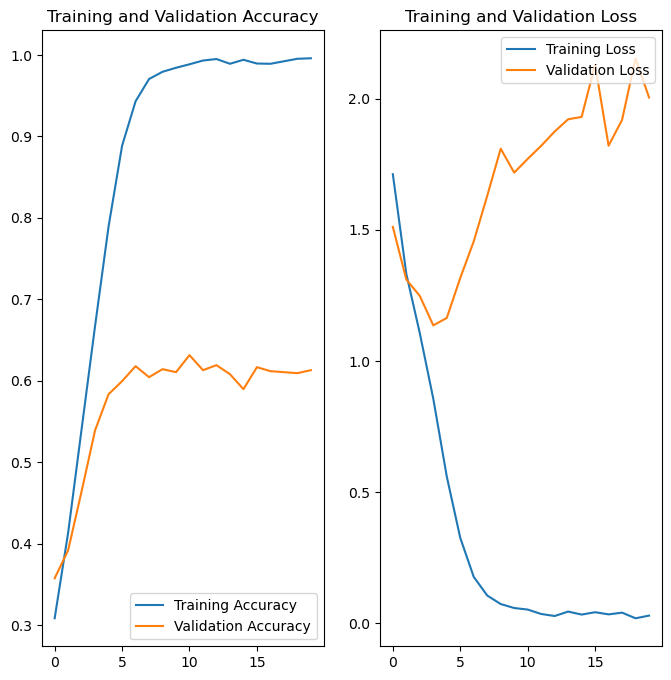

In [18]:
plot_history(conv_hist)

### Model with convolutional neural network using image data generator

We define the width and height of the image to change to a shape that the transfer learning model allow as an input. We are going to use it during the notebook to define the input shape.

In [9]:
width_shape = 224
height_shape = 224
epochs = 50
batch_size = 32 

The code is using the `ImageDataGenerator` class from the Keras library in Python to create an instance of the generator with specific data augmentation parameters.

- `rescale`: This parameter scales the image data by the provided value, in this case by 1/255 to ensure that the pixel values are in the range of 0 to 1.

- The `zoom_range`, `shear_range`, `width_shift_range`, and `height_shift_range` parameters are all set to 0.2. These parameters are used to apply random zoom, shear, width shift, and height shift transformations to the images during the training process. This is done to increase the diversity of the training data, which can help the model generalize better to new images.

- `width_shift_range` and `height_shift_range`: These parameters randomly shift the images horizontally and vertically by a factor of width_shift_range and height_shift_range respectively. In this case, the images will be shifted horizontally and vertically by a maximum of 20% of their width and height.

- `horizontal_flip`: This parameter randomly flips the images horizontally. In this case, it is set to True so images will be flipped. This is another technique to increase the diversity of the training data.

- `validation_split`: This parameter sets aside a certain portion of the data (in this case 20%) for validation.

The generator can be used to generate batches of augmented images for training a model. This will help to prevent overfitting by providing the model with more diverse data during training.

In [10]:
#Define the image data generator of the training data
train_datagen = ImageDataGenerator( 
    rescale= 1./255,
    zoom_range=0.2,
    shear_range= 0.2,    
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split= 0.2)

#Define the image data generator of the validation data
valid_datagen = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

#Load the train data using the data generator created previously
train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "training",
    batch_size= batch_size)
    
#Load the validation data using the data generator created previously
valid_generator = valid_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "validation",
    batch_size= batch_size)


Found 3258 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


We print all classes and the first value to verify is correct

In [28]:

print(train_generator.class_indices)
print(train_generator.next()[0][1])

{'Bathroom': 0, 'Bedroom': 1, 'House Map': 2, 'Kitchen': 3, 'Living Room': 4}
[[[0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  ...
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]]

 [[0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  ...
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]]

 [[0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  ...
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]]

 ...

 [[0.91372555 0.91372555 0.91372555]
  [0.91372555 0.91372555 0.91372555]
  [0.91372555 0.91372555 0.91372555]
  ...
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 ]
  [0.9960785  0.9960785  0.9960785 

Plot examples of the images with data image generator where we can see the effects of the class

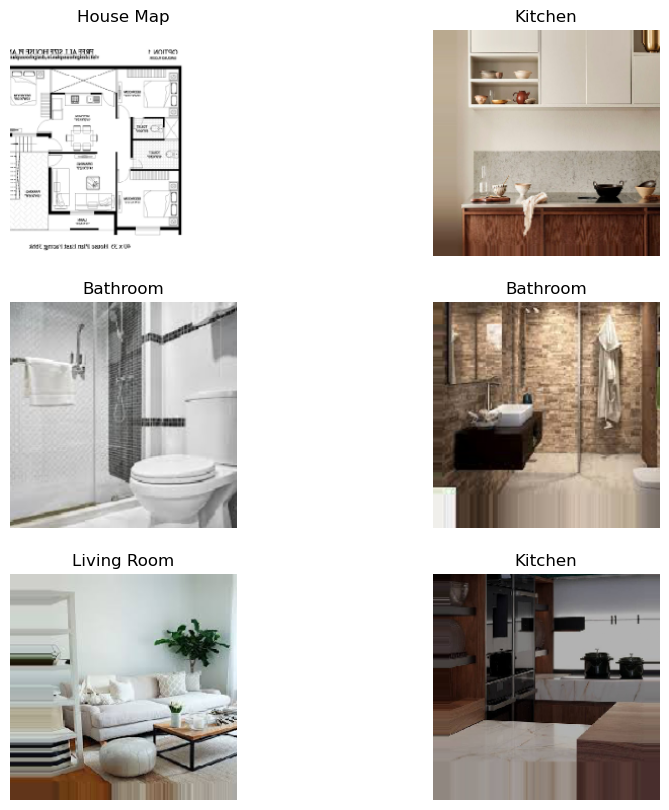

In [30]:
batch =  train_generator.next()
  
plt.figure(figsize=(10, 10))

for i in range(6):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(batch[0][i])
  plt.title(class_names[np.argmax(batch[1][i])])
  plt.axis("off")

In [31]:
model_conv_with_data_gen = def_conv_model(input_shape=(224,224,3))

In [32]:
model_conv_with_data_gen.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

conv_hist_with_data_generator = model_conv_with_data_gen.fit(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

Epoch 1/50
 87/102 [========================>.....] - ETA: 5s - loss: 1.7668 - accuracy: 0.2741

c:\Users\danie\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


102/102 [==============================] - 42s 399ms/step - loss: 1.7238 - accuracy: 0.2799 - val_loss: 1.5372 - val_accuracy: 0.3153
Epoch 2/50
102/102 [==============================] - 40s 396ms/step - loss: 1.4920 - accuracy: 0.3100 - val_loss: 1.3776 - val_accuracy: 0.3534
Epoch 3/50
102/102 [==============================] - 39s 381ms/step - loss: 1.3867 - accuracy: 0.3815 - val_loss: 1.3078 - val_accuracy: 0.4236
Epoch 4/50
102/102 [==============================] - 38s 371ms/step - loss: 1.2986 - accuracy: 0.4254 - val_loss: 1.3193 - val_accuracy: 0.4483
Epoch 5/50
102/102 [==============================] - 38s 370ms/step - loss: 1.2436 - accuracy: 0.4484 - val_loss: 1.3805 - val_accuracy: 0.4717
Epoch 6/50
102/102 [==============================] - 40s 392ms/step - loss: 1.2185 - accuracy: 0.4533 - val_loss: 1.2364 - val_accuracy: 0.4803
Epoch 7/50
102/102 [==============================] - 40s 395ms/step - loss: 1.1986 - accuracy: 0.4570 - val_loss: 1.1783 - val_accuracy: 0.5

We can see with this model doesn't overfit with the train data like the one that doesn't use the Image data generator. Even we obtain a better accuracy then we are going to use this data for the transfer learning models.

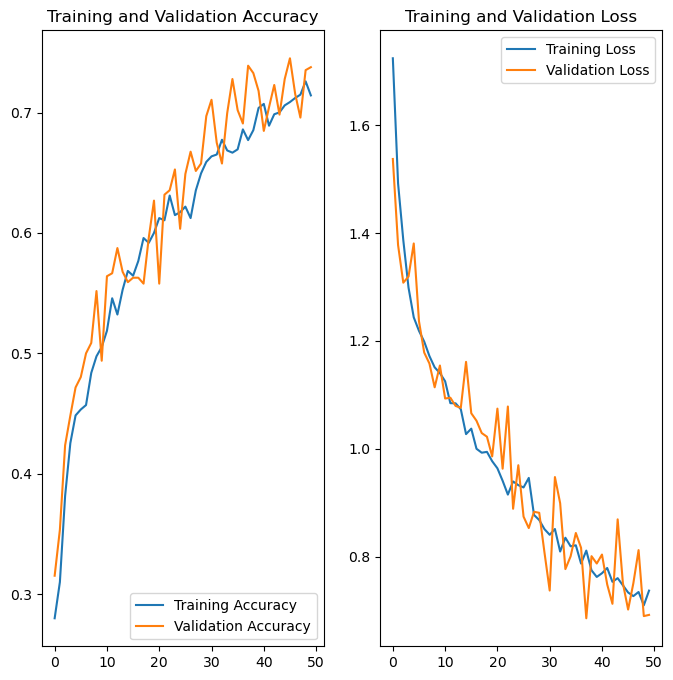

In [36]:
plot_history(conv_hist_with_data_generator,epochs=epochs)

### Defining a function to train a model using a pretrained model with a transfer learning technique

In [11]:
def train_transfer_learning_model(base_model,filepath):
  #Define the variables
  epochs = 20
  # Freeze base model layers
  for layer in base_model.layers:
    layer.trainable = False

  # Add new layers connected to the base model
  x=base_model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  x=Dense(1024,activation='relu')(x) #dense layer 2
  x=Dense(512,activation='relu')(x) #dense layer 3
  x = Dropout(0.5)(x)
  predictions=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

  # Create a model using the pretrained model
  transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model using SGD
  transfer_learning_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  transfer_learning_hist = transfer_learning_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size ,
        epochs= epochs,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples/valid_generator.batch_size,
        verbose=1)

  # Unfreeze all the layers of the model
  for layer in base_model.layers:
    layer.trainable = True

  # Compile the model but using a low learning rate
  transfer_learning_model.compile(optimizer=SGD(lr=0.0001, momentum= 0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  #Create a ModelCheckpoint callback to get the epoch with the best accuracy in the validation data
  callback = ModelCheckpoint(filepath=filepath,monitor="val_accuracy",mode="max",verbose=1,save_best_only=True)
  # Train the model again
  fine_tuning_hist = transfer_learning_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size ,
        epochs= epochs,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples/valid_generator.batch_size,
        verbose=1,
        callbacks= [callback])
  
  print("This is the historical of the transfer learning")
  plot_history(transfer_learning_hist,epochs)

  print("This is the historical of the fine tuning")
  plot_history(fine_tuning_hist,epochs)  

  return transfer_learning_model


### Transfer learning using MobileNetV2 model

c:\Users\danie\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
 48/101 [=============>................] - ETA: 22s - loss: 1.2676 - accuracy: 0.4758

c:\Users\danie\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


101/101 [==============================] - 47s 435ms/step - loss: 1.0282 - accuracy: 0.5970 - val_loss: 0.5340 - val_accuracy: 0.8140
Epoch 2/20
101/101 [==============================] - 44s 434ms/step - loss: 0.5824 - accuracy: 0.7845 - val_loss: 0.3953 - val_accuracy: 0.8461
Epoch 3/20
101/101 [==============================] - 43s 426ms/step - loss: 0.5007 - accuracy: 0.8201 - val_loss: 0.3919 - val_accuracy: 0.8436
Epoch 4/20
101/101 [==============================] - 45s 438ms/step - loss: 0.4574 - accuracy: 0.8355 - val_loss: 0.3779 - val_accuracy: 0.8559
Epoch 5/20
101/101 [==============================] - 44s 434ms/step - loss: 0.4289 - accuracy: 0.8422 - val_loss: 0.3212 - val_accuracy: 0.8793
Epoch 6/20
101/101 [==============================] - 43s 421ms/step - loss: 0.4039 - accuracy: 0.8484 - val_loss: 0.3158 - val_accuracy: 0.8855
Epoch 7/20
101/101 [==============================] - 44s 436ms/step - loss: 0.4000 - accuracy: 0.8554 - val_loss: 0.3271 - val_accuracy: 0.8

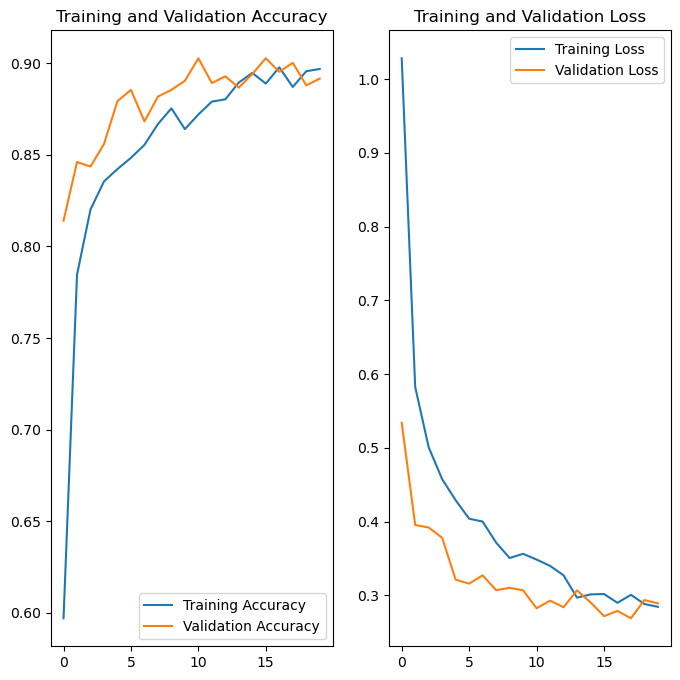

This is the historical of the fine tuning


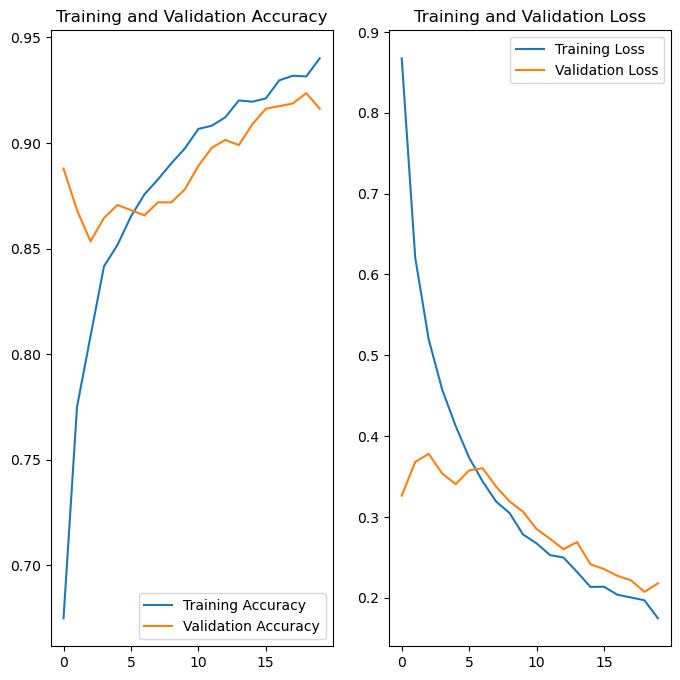

In [17]:
mobile_base=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model without the input layer

mobilenet_model = train_transfer_learning_model(mobile_base,"Models/mobilenet_model.h5")

In [32]:
mobilenet_model = load_model("Models/mobilenet_model.h5")
mobilenet_valid_results = mobilenet_model.evaluate(valid_generator)
print("Loss: ",mobilenet_valid_results[0])
print("Accuracy: ", mobilenet_valid_results[1])

26/26 [==============================] - 4s 128ms/step - loss: 0.2074 - accuracy: 0.9236
Loss:  0.20735040307044983
Accuracy:  0.9236453175544739


### Transfer learning using VGG16 model

c:\Users\danie\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
 12/101 [==>...........................] - ETA: 1:03 - loss: 1.5937 - accuracy: 0.2381

c:\Users\danie\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


101/101 [==============================] - 54s 449ms/step - loss: 1.5030 - accuracy: 0.3066 - val_loss: 1.3594 - val_accuracy: 0.4507
Epoch 2/20
101/101 [==============================] - 40s 397ms/step - loss: 1.3463 - accuracy: 0.4319 - val_loss: 1.2066 - val_accuracy: 0.4692
Epoch 3/20
101/101 [==============================] - 41s 399ms/step - loss: 1.2262 - accuracy: 0.4942 - val_loss: 1.0803 - val_accuracy: 0.5493
Epoch 4/20
101/101 [==============================] - 41s 400ms/step - loss: 1.1399 - accuracy: 0.5307 - val_loss: 0.9901 - val_accuracy: 0.6108
Epoch 5/20
101/101 [==============================] - 39s 385ms/step - loss: 1.0821 - accuracy: 0.5595 - val_loss: 0.9818 - val_accuracy: 0.5579
Epoch 6/20
101/101 [==============================] - 39s 387ms/step - loss: 1.0318 - accuracy: 0.5786 - val_loss: 0.8997 - val_accuracy: 0.6256
Epoch 7/20
101/101 [==============================] - 39s 385ms/step - loss: 0.9739 - accuracy: 0.6059 - val_loss: 0.8565 - val_accuracy: 0.6

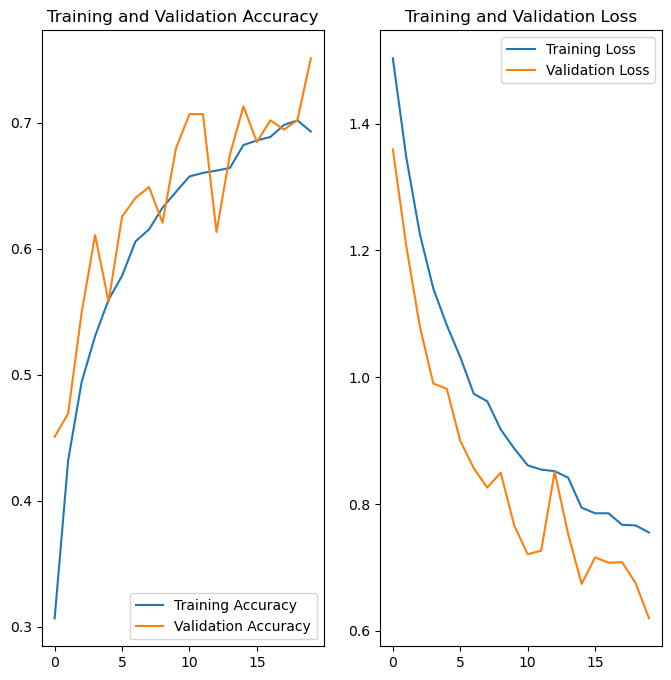

This is the historical of the fine tuning


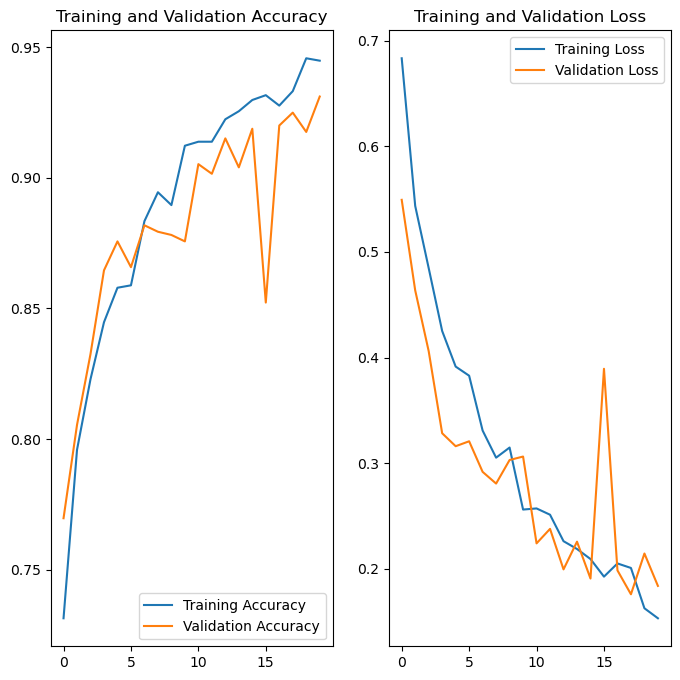

In [12]:
vgg_base=VGG16(weights='imagenet',include_top=False) #imports the VGG model without the input layer

vgg_model = train_transfer_learning_model(vgg_base,"Models/vgg_model.h5")

In [29]:
vgg_model = load_model("Models/vgg_model.h5")
vgg_valid_results = vgg_model.evaluate(valid_generator)
print("Loss: ",vgg_valid_results[0])
print("Accuracy: ", vgg_valid_results[1])

26/26 [==============================] - 5s 155ms/step - loss: 0.1839 - accuracy: 0.9310
Loss:  0.1838543564081192
Accuracy:  0.931034505367279


### Transfer learning using InceptionV3 model

Epoch 1/20
 51/101 [==============>...............] - ETA: 20s - loss: 1.2442 - accuracy: 0.4846

c:\Users\danie\miniconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


101/101 [==============================] - 51s 453ms/step - loss: 1.0095 - accuracy: 0.6007 - val_loss: 0.4818 - val_accuracy: 0.8350
Epoch 2/20
101/101 [==============================] - 44s 434ms/step - loss: 0.6490 - accuracy: 0.7557 - val_loss: 0.4533 - val_accuracy: 0.8300
Epoch 3/20
101/101 [==============================] - 44s 435ms/step - loss: 0.5981 - accuracy: 0.7747 - val_loss: 0.3827 - val_accuracy: 0.8571
Epoch 4/20
101/101 [==============================] - 43s 426ms/step - loss: 0.5438 - accuracy: 0.7950 - val_loss: 0.3701 - val_accuracy: 0.8719
Epoch 5/20
101/101 [==============================] - 44s 435ms/step - loss: 0.5153 - accuracy: 0.8051 - val_loss: 0.3524 - val_accuracy: 0.8658
Epoch 6/20
101/101 [==============================] - 44s 431ms/step - loss: 0.5028 - accuracy: 0.8085 - val_loss: 0.3565 - val_accuracy: 0.8633
Epoch 7/20
101/101 [==============================] - 43s 425ms/step - loss: 0.4896 - accuracy: 0.8143 - val_loss: 0.3553 - val_accuracy: 0.8

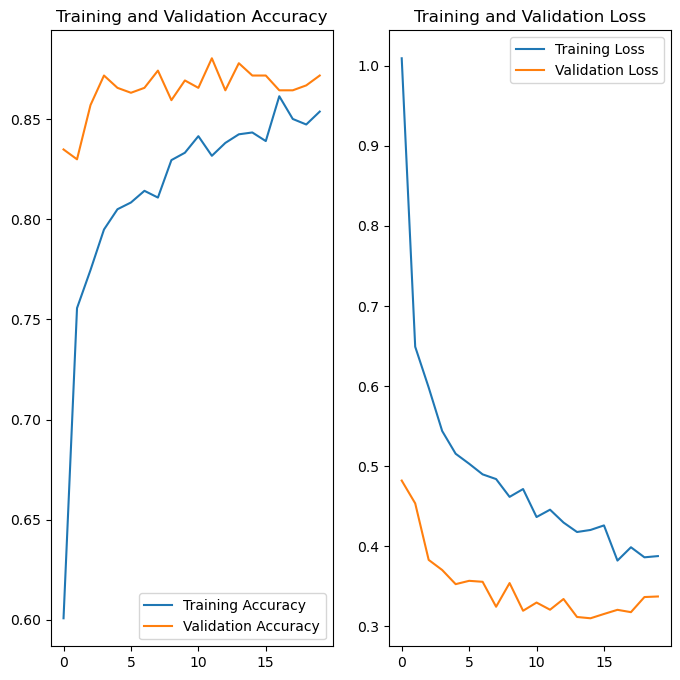

This is the historical of the fine tuning


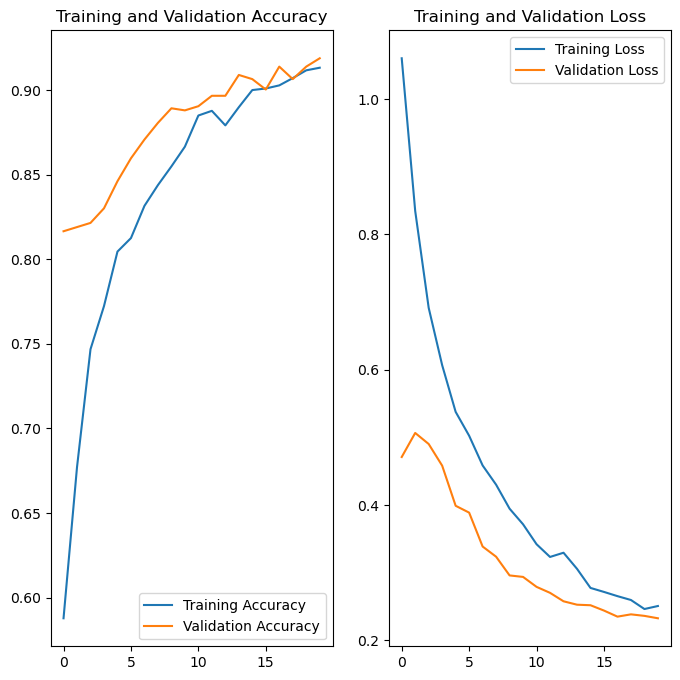

In [21]:
inception_base=InceptionV3(weights='imagenet',include_top=False) #imports the Inception model without the input layer

inception_model = train_transfer_learning_model(inception_base,"Models/inception_model.h5")

In [28]:
inception_model = load_model("Models/inception_model.h5")
inception_valid_results = inception_model.evaluate(valid_generator)
print("Loss: ",inception_valid_results[0])
print("Accuracy: ", inception_valid_results[1])

26/26 [==============================] - 5s 130ms/step - loss: 0.2324 - accuracy: 0.9187
Loss:  0.23243874311447144
Accuracy:  0.9187192320823669


### Comparing the models

#### Load test data

In this case we desactivate the shuffle to evaluate the data with confusion matrix and classifcation report otherwise we would not be able to relate the predictions to the actual classes.

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)


test_generator = test_datagen.flow_from_directory(test_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    shuffle= False,
    batch_size= batch_size)


Found 691 images belonging to 5 classes.


We evaluate all models using the test data and pick the one that have the best performance. All have almost the same performance, but the VGG16 model obtains slightly better results in the test and validation accuracy. That why we are going to pick that model for our room classifier.

In [33]:
inception_results = inception_model.evaluate(test_generator)
print("InceptionV3 Validation accuracy: ",inception_valid_results[1])
print("InceptionV3 Test accuracy: ", inception_results[1])

mobilenet_results = mobilenet_model.evaluate(test_generator)
print("MobilenetV2 Validation accuracy: ",mobilenet_valid_results[1])
print("MobilenetV2 Test accuracy: ", mobilenet_results[1])

vgg_results = vgg_model.evaluate(test_generator)
print("VGG15 Validation accuracy: ",vgg_valid_results[1])
print("VGG15 Test accuracy: ", vgg_results[1])

22/22 [==============================] - 2s 70ms/step - loss: 0.3715 - accuracy: 0.8611
InceptionV3 Validation accuracy:  0.9187192320823669
InceptionV3 Test accuracy:  0.8610709309577942
22/22 [==============================] - 1s 48ms/step - loss: 0.4105 - accuracy: 0.8640
MobilenetV2 Validation accuracy:  0.9236453175544739
MobilenetV2 Test accuracy:  0.8639652729034424
22/22 [==============================] - 2s 108ms/step - loss: 0.3420 - accuracy: 0.8842
VGG15 Validation accuracy:  0.931034505367279
VGG15 Test accuracy:  0.8842257857322693


## Evaluate the model

#### Load images and test if the prediction of the model is correct

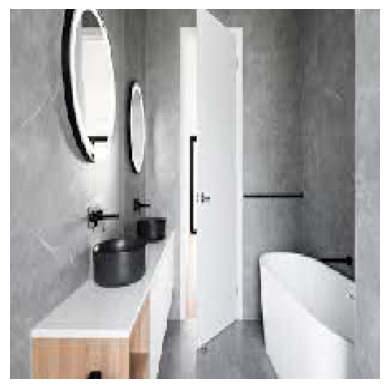

1/1 [==============================] - 1s 1s/step
The prediction is Bathroom


In [34]:
def load_image(img_path, show=False):

    #load the image with the target shape defined before
    img = load_img(img_path, target_size=(width_shape, height_shape))
    img_tensor =    img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.  #Normalize it
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  

img_path = os.path.join(test_dir,"Bathroom/0.jpg")
new_image = load_image(img_path,show=True)

pred = vgg_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


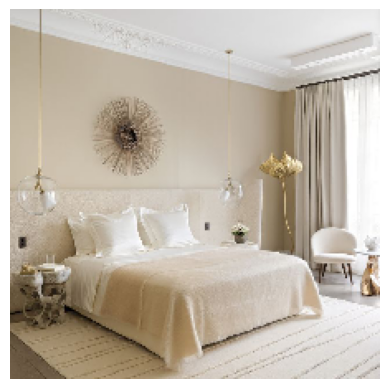

1/1 [==============================] - 0s 42ms/step
The prediction is Bedroom


In [35]:
img_path = os.path.join(test_dir,"Bedroom/dormitorio_paris.jpg")
# img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\Bedroom\dormitorio_paris.jpg'
new_image = load_image(img_path,show=True)

pred = vgg_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


#### Evaluate the model

We have 88% of accuracy using this VGG16 transfer learning model. That is a good result having that reduced level of images for the training that thanks of the techniches of transfer learning and fine tuning and the ImageDataGenerator function of Keras we achieved.

In [36]:
print("Loss: ",vgg_results[0])
print("Accuracy: ", vgg_results[1])

Loss:  0.34203705191612244
Accuracy:  0.8842257857322693


From the confusion matrix, we can draw the following conclusions:

1- The classifier has a relatively high accuracy in classifying the rooms.

2- The classifier has a slightly higher error rate for classifying the kitchen, bathroom, and living room, compared to the other classes, but still performs well. This may be due to the classifier struggling to differentiate between the features that distinguish these classes.

3- The classifier has a relatively low error rate in classifying the bedroom, which may indicate that the features that distinguish bedrooms from the other classes are well captured by the classifier.

4- The classifier has an impressive performance in classifying the house maps, with a perfect accuracy of 100%.


Confusion Matrix

In [37]:
#Predict the target using the model and test data
preds = vgg_model.predict(test_generator)
#Take the class with more probability
y_pred = np.argmax(preds,axis = 1)
# Save the real classes
true_classes = test_generator.classes


22/22 [==============================] - 3s 124ms/step


[[147   2   0  13   2]
 [  2  88   0   2   2]
 [  0   0  71   0   1]
 [  9   5   0 168  12]
 [  2  20   0   8 137]]


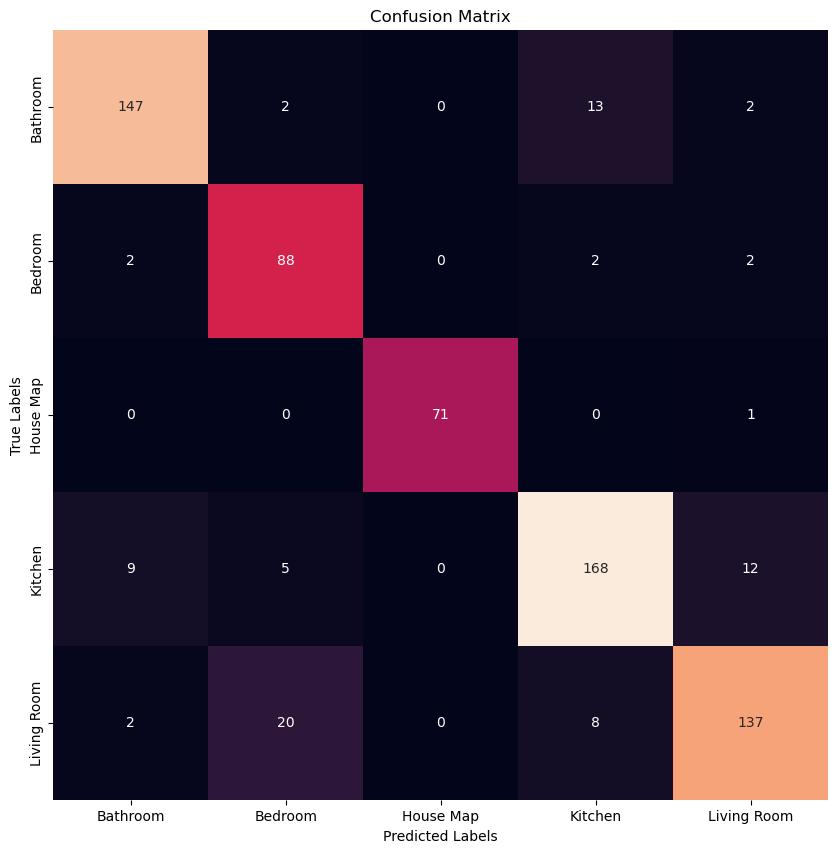

In [40]:
# Create the confusion matrix
confmx = confusion_matrix(true_classes, y_pred)
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(confmx,annot=True, ax = ax,fmt='.0f',xticklabels=class_names,yticklabels=class_names, cbar= False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

Using this classification report we can represent the performance metrics of a room image classifier. The classifier has been evaluated on a test dataset containing 691 images of different rooms such as Bathroom, Bedroom, House Map, Kitchen, and Living Room.

The model has achieved a weighted average of 0.89 for precision, recall, and f1-score, which indicates that the model is able to accurately classify the majority of the images in the test set. The individual performance of each class varies, with some classes performing better than others. The classifier has performed particularly well for the 'House Map' class, with a precision, recall and f1-score of 1.00, indicating 100% accuracy in classifying images in this class. On the other hand, the classifier has performed less well for the 'Bedroom' class, with a precision, recall and f1-score of 0.77, 0.94 and 0.84 respectively. Overall, the results indicate that the room image classifier has performed well and has the potential for further improvement.

Report of the classification

In [39]:
print(classification_report(true_classes,y_pred,target_names=class_names))

              precision    recall  f1-score   support

    Bathroom       0.92      0.90      0.91       164
     Bedroom       0.77      0.94      0.84        94
   House Map       1.00      0.99      0.99        72
     Kitchen       0.88      0.87      0.87       194
 Living Room       0.89      0.82      0.85       167

    accuracy                           0.88       691
   macro avg       0.89      0.90      0.89       691
weighted avg       0.89      0.88      0.88       691



Overall, the results of the model are very impressive. With an accuracy of over 93% on the validation data and 88% on the test data, it is clear that the model is performing well in classifying room images. Furthermore, the fact that the model does not have any type of room that it does not classify well is also a testament to its effectiveness. This is an important factor, as it ensures that the model is able to accurately identify all types of rooms, regardless of their characteristics.